In [1]:
from IPython.display import display, HTML

img_url = "https://www.kaggle.com/competitions/91719/images/header"

display(HTML(f'''
<div style="text-align: center;">
    <img src="{img_url}" width="800">
</div>
'''))



In [2]:
# =========================
# 1. Install required libs
# =========================
!pip install ydata-profiling catboost

# =========================
# 2. Import libraries
# =========================
import pandas as pd
from ydata_profiling import ProfileReport
from catboost import CatBoostClassifier

In [3]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:

# =========================
# 3. Load data
# =========================

data_train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")

data_test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")

In [5]:
# Check structure
print(data_train.shape, data_test.shape)

(750000, 18) (250000, 17)


In [6]:
data_train.head()

id  age          job  marital  education default  balance housing loan  \
0   0   42   technician  married  secondary      no        7      no   no   
1   1   38  blue-collar  married  secondary      no      514      no   no   
2   2   36  blue-collar  married  secondary      no      602     yes   no   
3   3   27      student   single  secondary      no       34     yes   no   
4   4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1

In [7]:
data_test.head()

id  age            job  marital  education default  balance housing  \
0  750000   32    blue-collar  married  secondary      no     1397     yes   
1  750001   44     management  married   tertiary      no       23     yes   
2  750002   36  self-employed  married    primary      no       46     yes   
3  750003   58    blue-collar  married  secondary      no    -1380     yes   
4  750004   28     technician   single  secondary      no     1950     yes   

  loan   contact  day month  duration  campaign  pdays  previous poutcome  
0   no   unknown   21   may       224         1     -1         0  unknown  
1   no  cellular    3   apr       586         2     -1         0  unknown  
2  yes  cellular   13   may       111         2     -1         0  unknown  
3  yes   unknown   29   may       125         1     -1         0  unknown  
4   no  cellular   22   jul       181         1     -1         0  unknown

In [8]:
# =========================
# 4. Quick EDA with ydata-profiling
# =========================
profile = ProfileReport(data_train, title="EDA Report", explorative=True)
profile.to_file("eda_report.html")  

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
import os
print(os.listdir("/kaggle/working"))


['eda_report.html', '.virtual_documents']


In [10]:
profile.to_notebook_iframe()


In [11]:
# =========================
# 5. Prepare data
# =========================
data_train.drop(columns = ['id'], inplace = True)



In [12]:
data_train.head()

age          job  marital  education default  balance housing loan  \
0   42   technician  married  secondary      no        7      no   no   
1   38  blue-collar  married  secondary      no      514      no   no   
2   36  blue-collar  married  secondary      no      602     yes   no   
3   27      student   single  secondary      no       34     yes   no   
4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1

In [13]:
# Keep the IDs separately
test_ids = data_test["id"]

# Drop 'id' before prediction
test_features = data_test.drop("id", axis=1)



In [14]:
test_features.head()

age            job  marital  education default  balance housing loan  \
0   32    blue-collar  married  secondary      no     1397     yes   no   
1   44     management  married   tertiary      no       23     yes   no   
2   36  self-employed  married    primary      no       46     yes  yes   
3   58    blue-collar  married  secondary      no    -1380     yes  yes   
4   28     technician   single  secondary      no     1950     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  
0   unknown   21   may       224         1     -1         0  unknown  
1  cellular    3   apr       586         2     -1         0  unknown  
2  cellular   13   may       111         2     -1         0  unknown  
3   unknown   29   may       125         1     -1         0  unknown  
4  cellular   22   jul       181         1     -1         0  unknown

In [15]:
# Target column value counts

data_train['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

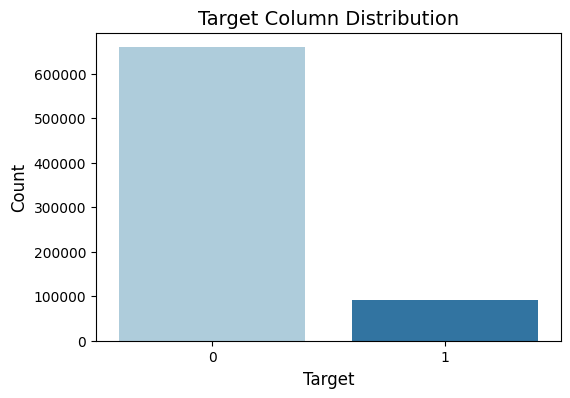

In [16]:
# Target column distribution

plt.figure(figsize=(6,4))
sns.countplot(x = 'y', data = data_train, palette = "Paired")
plt.title("Target Column Distribution", fontsize = 14)
plt.xlabel("Target", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

## The target column is highly imbalanced

# Train-Test Splitting¶

In [17]:
X = data_train.drop(columns = ['y'])
Y = data_train['y']

In [18]:
# Identify categorical columns (object or category dtype)
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical features:", cat_features)

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [19]:

# =========================
# 6. Train CatBoost model
# =========================
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    eval_metric="AUC",
    random_seed=42,
    verbose=100
)

model.fit(X, Y, cat_features=cat_features)

0:	total: 1.04s	remaining: 8m 38s
100:	total: 1m 12s	remaining: 4m 48s
200:	total: 2m 27s	remaining: 3m 39s
300:	total: 3m 40s	remaining: 2m 25s
400:	total: 4m 56s	remaining: 1m 13s
499:	total: 6m 11s	remaining: 0us


In [20]:
# Predict probabilities
preds = model.predict_proba(test_features)[:, 1 ]# probability of class 1 

# Create submission
submission = pd.DataFrame({
    "id": test_ids,
    "y": preds
})




In [21]:
submission

id         y
0       750000  0.005948
1       750001  0.119125
2       750002  0.000151
3       750003  0.000037
4       750004  0.039127
...        ...       ...
249995  999995  0.000290
249996  999996  0.123149
249997  999997  0.671283
249998  999998  0.000967
249999  999999  0.102797

[250000 rows x 2 columns]

In [22]:
submission.to_csv("submission.csv", index=False)